In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import cv2
import imageio
import matplotlib.image as mpimg
from skimage import io
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers.legacy import RMSprop,SGD
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from statistics import mode
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalMaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

2024-06-01 11:28:28.600243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 11:28:28.600358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 11:28:28.747011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def gray2RGB(array2d):
    array3d = np.tile(array2d[:,:,np.newaxis],3)
    return array3d

def all_img_rgb_converter(arrays2d):

    len, width, height = arrays2d.shape
    arrays3d = []

    for i in range(len):
        array3d = gray2RGB(arrays2d[i,:,:])
        arrays3d.append(array3d)

    arrays3d = np.array(arrays3d)
    return arrays3d

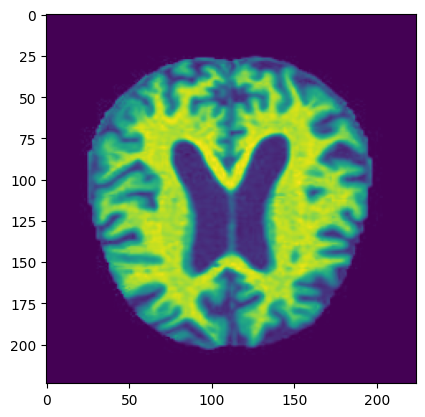

In [5]:
img_path = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg"
image = io.imread(img_path)
img = cv2.resize(image, (224,224), cv2.INTER_AREA)
img=img/255.0
plt.imshow(img)

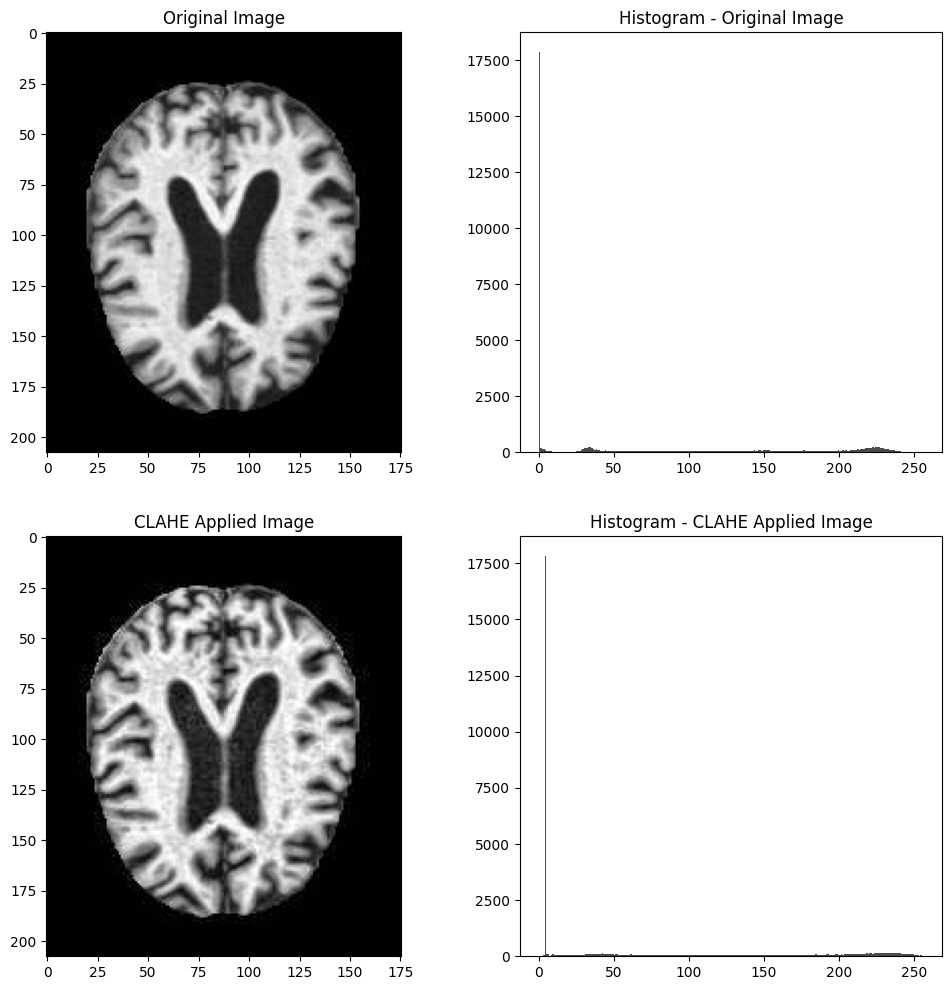

In [6]:
image = io.imread(img_path)
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16, 16))
cl_img = clahe.apply(image)

# Görüntüleri ve histogramlarını görselleştirin
plt.figure(figsize=(12, 12))

# Orjinal resim
plt.subplot(221)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

# Histogram - Original Image
plt.subplot(222)
plt.title('Histogram - Original Image')
plt.hist(image.ravel(), bins=256, range=[0, 256], color='black', alpha=0.7)

# CLAHE Applied Image
plt.subplot(223)
plt.title('CLAHE Applied Image')
plt.imshow(cl_img, cmap='gray')

# Histogram - CLAHE Applied Image
plt.subplot(224)
plt.title('Histogram - CLAHE Applied Image')
plt.hist(cl_img.ravel(), bins=256, range=[0, 256], color='black', alpha=0.7)

plt.show()

In [7]:
image.shape

(208, 176)

(224, 224, 3)


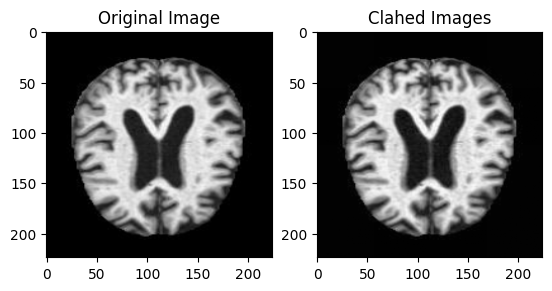

In [6]:
# First approach the clahe method as first clahe appplication before process resize and converting to 3d sahpe

image = io.imread(img_path)

# Orjinal resim
plt.subplot(121)
plt.title('Original Image')
image_res = cv2.resize(image, (224,224), cv2.INTER_AREA)
image_res_3d = gray2RGB(image_res)
plt.imshow(image_res_3d, cmap='gray')


plt.subplot(122)
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
cl_img = clahe.apply(image)
img = cv2.resize(cl_img, (224,224), cv2.INTER_AREA)
img=img/255.0
img_rgb = gray2RGB(img)
print(img_rgb.shape)
plt.title('Clahed Images')
plt.imshow(img_rgb, cmap='gray')


(224, 224, 3)
(224, 224, 3)


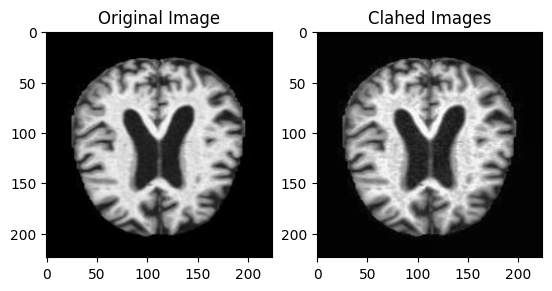

In [7]:
# second approach 

image = io.imread(img_path)

# Orjinal resim
plt.subplot(121)
plt.title('Original Image')
image_res = cv2.resize(image, (224,224), cv2.INTER_AREA)
image_res_3d = gray2RGB(image_res)
print(image_res_3d.shape)
plt.imshow(image_res_3d, cmap='gray')


plt.subplot(122)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))
image_res_3d_cl_img_2 = clahe.apply(image_res_3d[:,:,0])
image_res_3d_cl_img_2 = gray2RGB(image_res_3d_cl_img_2)
print(image_res_3d_cl_img_2.shape)
plt.title('Clahed Images')
plt.imshow(image_res_3d_cl_img_2, cmap='gray')


In [8]:
a = image_res_3d == image_res_3d_cl_img_2
a

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [9]:
true_val = 0
false_val = 0
shape_inf = a.shape

for i in range(224):
    for j in range(224):
        for k in range(3):
            if a[i,j,k] == True:
                true_val += 1
            else:
                false_val += 1
            

# Proposed method our clahe method

(224, 224, 3)
(224, 224, 3)


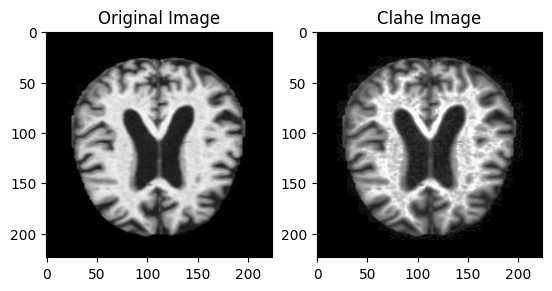

In [10]:

image = io.imread(img_path)

# Orjinal resim
plt.subplot(121)
plt.title('Original Image')
image_res = cv2.resize(image, (224,224), cv2.INTER_AREA)
image_res_3d = gray2RGB(image_res)
print(image_res_3d.shape)
plt.imshow(image_res_3d, cmap='gray')


# plt.subplot(222)
#Ham halde dağılımı inceleyelim
#plt.hist(image_res_3d[:,:,0].flat, bins=100, range=(0,255))



plt.subplot(122)
plt.title('Clahe Image')
lab = cv2.cvtColor(image_res_3d, cv2.COLOR_BGR2LAB)

l = lab[:,:,0]
a = lab[:,:,1]
b = lab[:,:,2]



#Geleneksel equalazation yapalım.
equalized = cv2.equalizeHist(l)

#Kanalları birleştirelim.
lab_img1_result = cv2.merge((equalized,a,b))

#Lab formatımızı eski haline bgr haline dönüştürelim
hist_eq_img = cv2.cvtColor(lab_img1_result, cv2.COLOR_LAB2BGR)

print(hist_eq_img.shape)

plt.imshow(hist_eq_img)

#plt.subplot(224)
#Geleneksel equlization sonrası dağılımı inceleyelim.
#plt.hist(equalized.flat, bins=100, range=(0,255))

Text(0.5, 1.0, 'Equalized Histogram Of The Image')

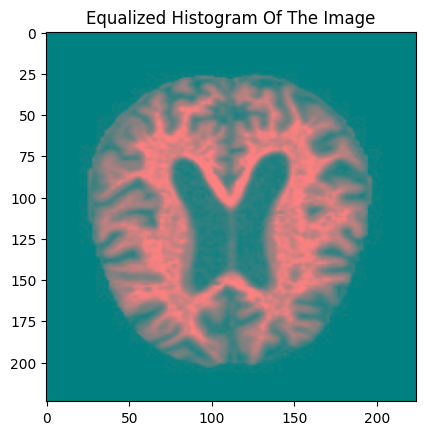

In [11]:
plt.imshow(lab_img1_result)
plt.title('Equalized Histogram Of The Image')

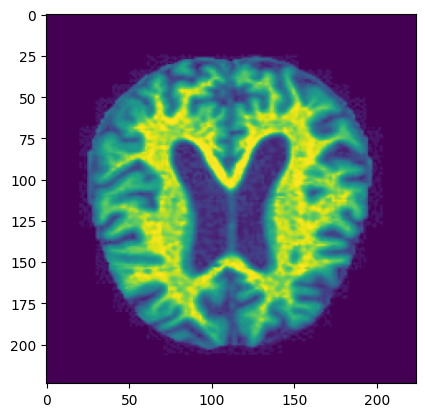

In [12]:

plt.imshow(cv2.equalizeHist(l))

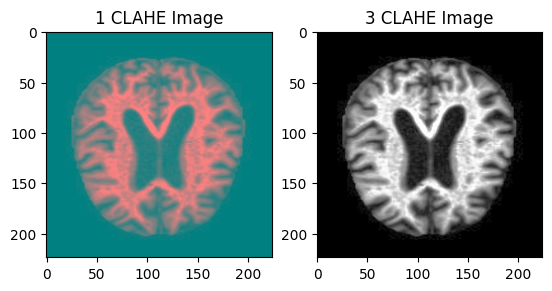

In [13]:
plt.subplot(121)
plt.title('1 CLAHE Image')
plt.imshow(cv2.merge((equalized,a,b)))

plt.subplot(122)
plt.title('3 CLAHE Image')
plt.imshow(cv2.merge((equalized,equalized,equalized)))

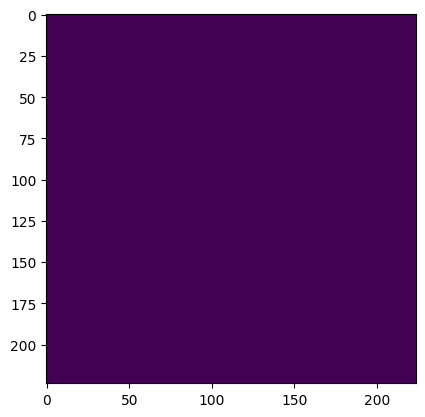

In [14]:
plt.imshow(a)

In [15]:
np.max(hist_eq_img)

255

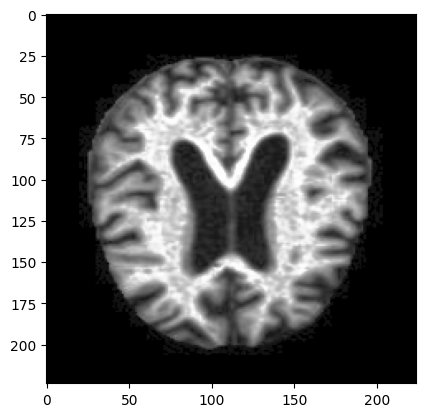

In [16]:
plt.imshow(hist_eq_img/255)